A. 可一键复现的飞桨算法代码（从上往下跑就行）

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import paddle
# 导入训练数据
df_train = pd.read_csv("train.csv")
df_train = df_train.drop(['id'],axis=1)
# 对特征进行归一化
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(df_train.iloc[:,1:])  
scaler_data = scaler.transform(df_train.iloc[:,1:])
# 将训练数据集和测试数据集按照8:2的比例分开
ratio = 0.8
offset = int(df_train.shape[0] * ratio)
train_data = np.c_[scaler_data,df_train.iloc[:,0]][:offset].copy()
test_data = np.c_[scaler_data,df_train.iloc[:,0]][offset:].copy()

c:\Users\Administer\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\Administer\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
# MLP模型组网搭建
n_input = 30
from paddle import nn
class Classifier(paddle.nn.Layer):
    def __init__(self):
        super(Classifier, self).__init__()
        self.l1 = paddle.nn.Linear(n_input, 1,)
        self.sigmoid = paddle.nn.Sigmoid()
        self.tanh = paddle.nn.Tanh()

    def forward(self, inputs):
        pred = self.l1(inputs)
        pred = self.sigmoid(pred)
        return pred

In [17]:
import paddle.nn.functional as F 
y_preds = []
train_nums = []
train_costs = []
labels_list = []
BATCH_SIZE = 8

def train(model):
    print('start training ... ')
    # 开启模型训练模式
    model.train()
    EPOCH_NUM = 5
    train_num = 0
    optimizer = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(train_data)
        # 将训练数据进行拆分，每个batch包含20条数据
        mini_batches = [train_data[k: k+BATCH_SIZE] for k in range(0, len(train_data), BATCH_SIZE)]
        for batch_id, data in enumerate(mini_batches):
            features_np = np.array(data[:, :-1], np.float32)
            labels_np = np.array(data[:, -1], np.float32)
            features = paddle.to_tensor(features_np)
            labels = paddle.to_tensor(labels_np)
            # 前向计算
            y_pred = model(features)
            y_pred = paddle.reshape(y_pred,shape=[-1])
            cost = F.binary_cross_entropy(y_pred, label=labels)
            train_cost = cost.numpy()[0]
            # 反向传播
            cost.backward()
            # 最小化loss，更新参数
            optimizer.step()
            # 清除梯度
            optimizer.clear_grad()
            
            if batch_id%30 == 0 and epoch_id%50 == 0:
                print("Pass:%d,Cost:%0.5f"%(epoch_id, train_cost))

            train_num = train_num + BATCH_SIZE
            train_nums.append(train_num)
            train_costs.append(train_cost)
        
model = Classifier()
train(model)

start training ... 
Pass:0,Cost:0.86671
Pass:0,Cost:0.79013
Pass:0,Cost:1.04299
Pass:0,Cost:0.79853
Pass:0,Cost:0.73267
Pass:0,Cost:0.61219
Pass:0,Cost:0.68484
Pass:0,Cost:0.90852
Pass:0,Cost:0.86299
Pass:0,Cost:0.51322
Pass:0,Cost:0.62164
Pass:0,Cost:0.81216
Pass:0,Cost:0.56250
Pass:0,Cost:0.86075
Pass:0,Cost:0.65832
Pass:0,Cost:0.68900
Pass:0,Cost:0.63759
Pass:0,Cost:0.55233
Pass:0,Cost:0.49126
Pass:0,Cost:0.87729
Pass:0,Cost:0.49681
Pass:0,Cost:0.58876
Pass:0,Cost:0.65666
Pass:0,Cost:0.45699
Pass:0,Cost:0.46448
Pass:0,Cost:0.65284
Pass:0,Cost:0.45771
Pass:0,Cost:0.73397
Pass:0,Cost:0.49256
Pass:0,Cost:0.82530
Pass:0,Cost:0.82714
Pass:0,Cost:0.53330
Pass:0,Cost:0.90595
Pass:0,Cost:0.44770
Pass:0,Cost:0.77465
Pass:0,Cost:0.67746
Pass:0,Cost:0.66726
Pass:0,Cost:0.63361
Pass:0,Cost:0.85097
Pass:0,Cost:0.67303
Pass:0,Cost:0.60682
Pass:0,Cost:0.83814
Pass:0,Cost:0.65574
Pass:0,Cost:0.56171
Pass:0,Cost:0.47114
Pass:0,Cost:0.78544
Pass:0,Cost:0.63217
Pass:0,Cost:0.78212
Pass:0,Cost:0.47534


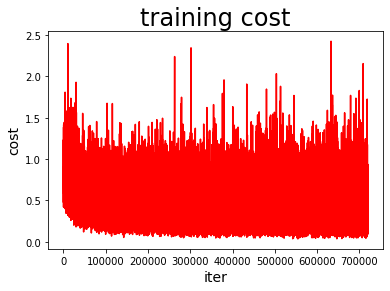

In [19]:
def draw_train_process(iters, train_costs):
    plt.title("training cost", fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs, color='red', label='training cost')
    plt.show()


import matplotlib
matplotlib.use('TkAgg')
draw_train_process(train_nums, train_costs)

In [30]:
def predict_accurancy(model,infer_features,infer_labels=None):
    fetch_list = model.forward(infer_features)
    # 压缩为一维张量
    fetch_list = paddle.reshape(fetch_list,shape=[-1])
    if infer_labels == None:
        return fetch_list,0
    plt.scatter(fetch_list,infer_labels)
    n_accu = 0
    for i,j in zip(fetch_list,infer_labels):
        if (i>0.5 and j==1) or (i<=0.5 and j==0):
            n_accu += 1
    accurancy_score = n_accu / len(infer_labels)
    return fetch_list,accurancy_score

In [ ]:
# 训练集上准确率
infer_features_np = np.array(train_data[:,:-1]).astype("float32")
infer_labels_np = np.array(train_data[:,-1]).astype("float32")

infer_features = paddle.to_tensor(infer_features_np)
infer_labels = paddle.to_tensor(infer_labels_np)

predict_accurancy(model,infer_features,infer_labels)

0.8297777777777777


(Tensor(shape=[36000], dtype=float32, place=Place(cpu), stop_gradient=False,
        [0.02543540, 0.87967950, 0.49644384, ..., 0.99905628, 0.95254171,
         0.31114933]),
 0.8297777777777777)

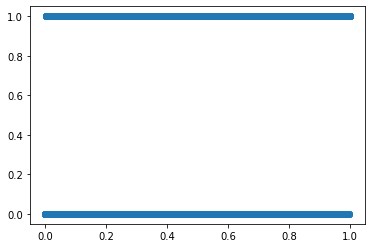

In [29]:
# 验证集上准确率
infer_features_np = np.array(test_data[:,:-1]).astype("float32")
infer_labels_np = np.array(test_data[:,-1]).astype("float32")

infer_features = paddle.to_tensor(infer_features_np)
infer_labels = paddle.to_tensor(infer_labels_np)

predict_accurancy(model,infer_features,infer_labels)

In [95]:
# 导入测试集数据
df_test = pd.read_csv("test.csv")
df_test = df_test.drop(labels=['id'],axis=1)
scaler_data = scaler.transform(df_test)
infer_features_np = np.array(scaler_data).astype("float32")
infer_features = paddle.to_tensor(infer_features_np)
prediction = predict_accurancy(model,infer_features)[0]
prediction = np.array(prediction)
prediction = np.where(prediction > 0.5, 1, 0)
pd.DataFrame({'win':prediction}).to_csv('submission.csv',encoding='utf_8_sig',index=False)

B. 模型文件对应的checkpoint为83，比最好成绩84.5（随机森林）稍微低了些，超参数和特征工程还有提升空间

C. 代码内容说明
1. 读取train.csv和test.csv中的数据
1. 转为paddle框架下的tensor
1. 按照8:2在train中拆分训练集和验证集
1. 把训练集喂给模型进行训练
1. 检测模型在训练集和验证集上的accuracy分数
1. 输出模型对测试集的预测结果

D. 模型构建思路及调优过程
1. 算法思路步骤参考**C. 代码内容说明**部分
1. 数据增强/清洗策略
    特征工程上可以继续改进，例如法术伤害和物理伤害与总伤害能不能进行统一
1. 调参优化策略
    主要考虑从优化器和激活函数处进行优化，网络结构不需要超过两层即可，甚至一层都能达到约82的准确率
1. 训练脚本/代码
    ```py
    import paddle.nn.functional as F 
    y_preds = []
    train_nums = []
    train_costs = []
    labels_list = []
    BATCH_SIZE = 8

    def train(model):
        print('start training ... ')
        # 开启模型训练模式
        model.train()
        EPOCH_NUM = 5
        train_num = 0
        optimizer = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
        for epoch_id in range(EPOCH_NUM):
            # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
            np.random.shuffle(train_data)
            # 将训练数据进行拆分，每个batch包含20条数据
            mini_batches = [train_data[k: k+BATCH_SIZE] for k in range(0, len(train_data), BATCH_SIZE)]
            for batch_id, data in enumerate(mini_batches):
                features_np = np.array(data[:, :-1], np.float32)
                labels_np = np.array(data[:, -1], np.float32)
                features = paddle.to_tensor(features_np)
                labels = paddle.to_tensor(labels_np)
                # 前向计算
                y_pred = model(features)
                y_pred = paddle.reshape(y_pred,shape=[-1])
                cost = F.binary_cross_entropy(y_pred, label=labels)
                train_cost = cost.numpy()[0]
                # 反向传播
                cost.backward()
                # 最小化loss，更新参数
                optimizer.step()
                # 清除梯度
                optimizer.clear_grad()
                
                if batch_id%30 == 0 and epoch_id%50 == 0:
                    print("Pass:%d,Cost:%0.5f"%(epoch_id, train_cost))

                train_num = train_num + BATCH_SIZE
                train_nums.append(train_num)
                train_costs.append(train_cost)
            
    model = Classifier()
    train(model)
    ```
1. 测试脚本/代码
    ```py
    def predict_accurancy(model,infer_features,infer_labels=None):
        fetch_list = model.forward(infer_features)
        # 压缩为一维张量
        fetch_list = paddle.reshape(fetch_list,shape=[-1])
        if infer_labels == None:
            return fetch_list,0
        plt.scatter(fetch_list,infer_labels)
        n_accu = 0
        for i,j in zip(fetch_list,infer_labels):
            if (i>0.5 and j==1) or (i<=0.5 and j==0):
                n_accu += 1
        accurancy_score = n_accu / len(infer_labels)
        return fetch_list,accurancy_score

    # 验证集上准确率
    infer_features_np = np.array(test_data[:,:-1]).astype("float32")
    infer_labels_np = np.array(test_data[:,-1]).astype("float32")

    infer_features = paddle.to_tensor(infer_features_np)
    infer_labels = paddle.to_tensor(infer_labels_np)

    predict_accurancy(model,infer_features,infer_labels)
    ```